In [52]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as py
from tqdm import tqdm
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import median_absolute_error

import torch 
from torch import nn
from torch import optim

#from tqdm import tqdm

In [2]:
py.init_notebook_mode()

In [3]:
data_test = pd.read_csv(f'data/test.csv', index_col='id')
data_train = pd.read_csv(f'data/train.csv', index_col='id')

In [4]:
print(f'train shape: {data_train.shape}\ntest_shape: {data_test.shape}"')

train shape: (10407, 12)
test_shape: (6939, 11)"


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 1.0 MB


In [6]:
data_train.head()

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
id                                                                           
0                100.0       0.841611                  10.0            4.8   
1                100.0       7.558488                  10.0            4.8   
2                 76.0       8.885992                  15.6            5.6   
3                100.0       8.795296                  10.0            4.8   
4                116.0       9.577996                  11.6            4.8   

    atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
id                                                                
0              20.612526           11.08810               2.766   
1              20.298893           12.04083               2.755   
2              33.739258           12.08630               2.828   
3              20.213349           10.94850               2.648   
4              24.988133           11.82448               2.766   

    R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
id                                                                  
0                   1.732                  0.860         0.496070   
1                   1.631                  0.910         0.492719   
2                   1.788                  0.864         0.481478   
3                   1.626                  0.936         0.489272   
4                   1.682                  0.896         0.492736   

    density_Average  Hardness  
id                             
0           0.91457       6.0  
1           0.71760       6.5  
2           1.50633       2.5  
3           0.78937       6.0  
4           1.86481       6.0

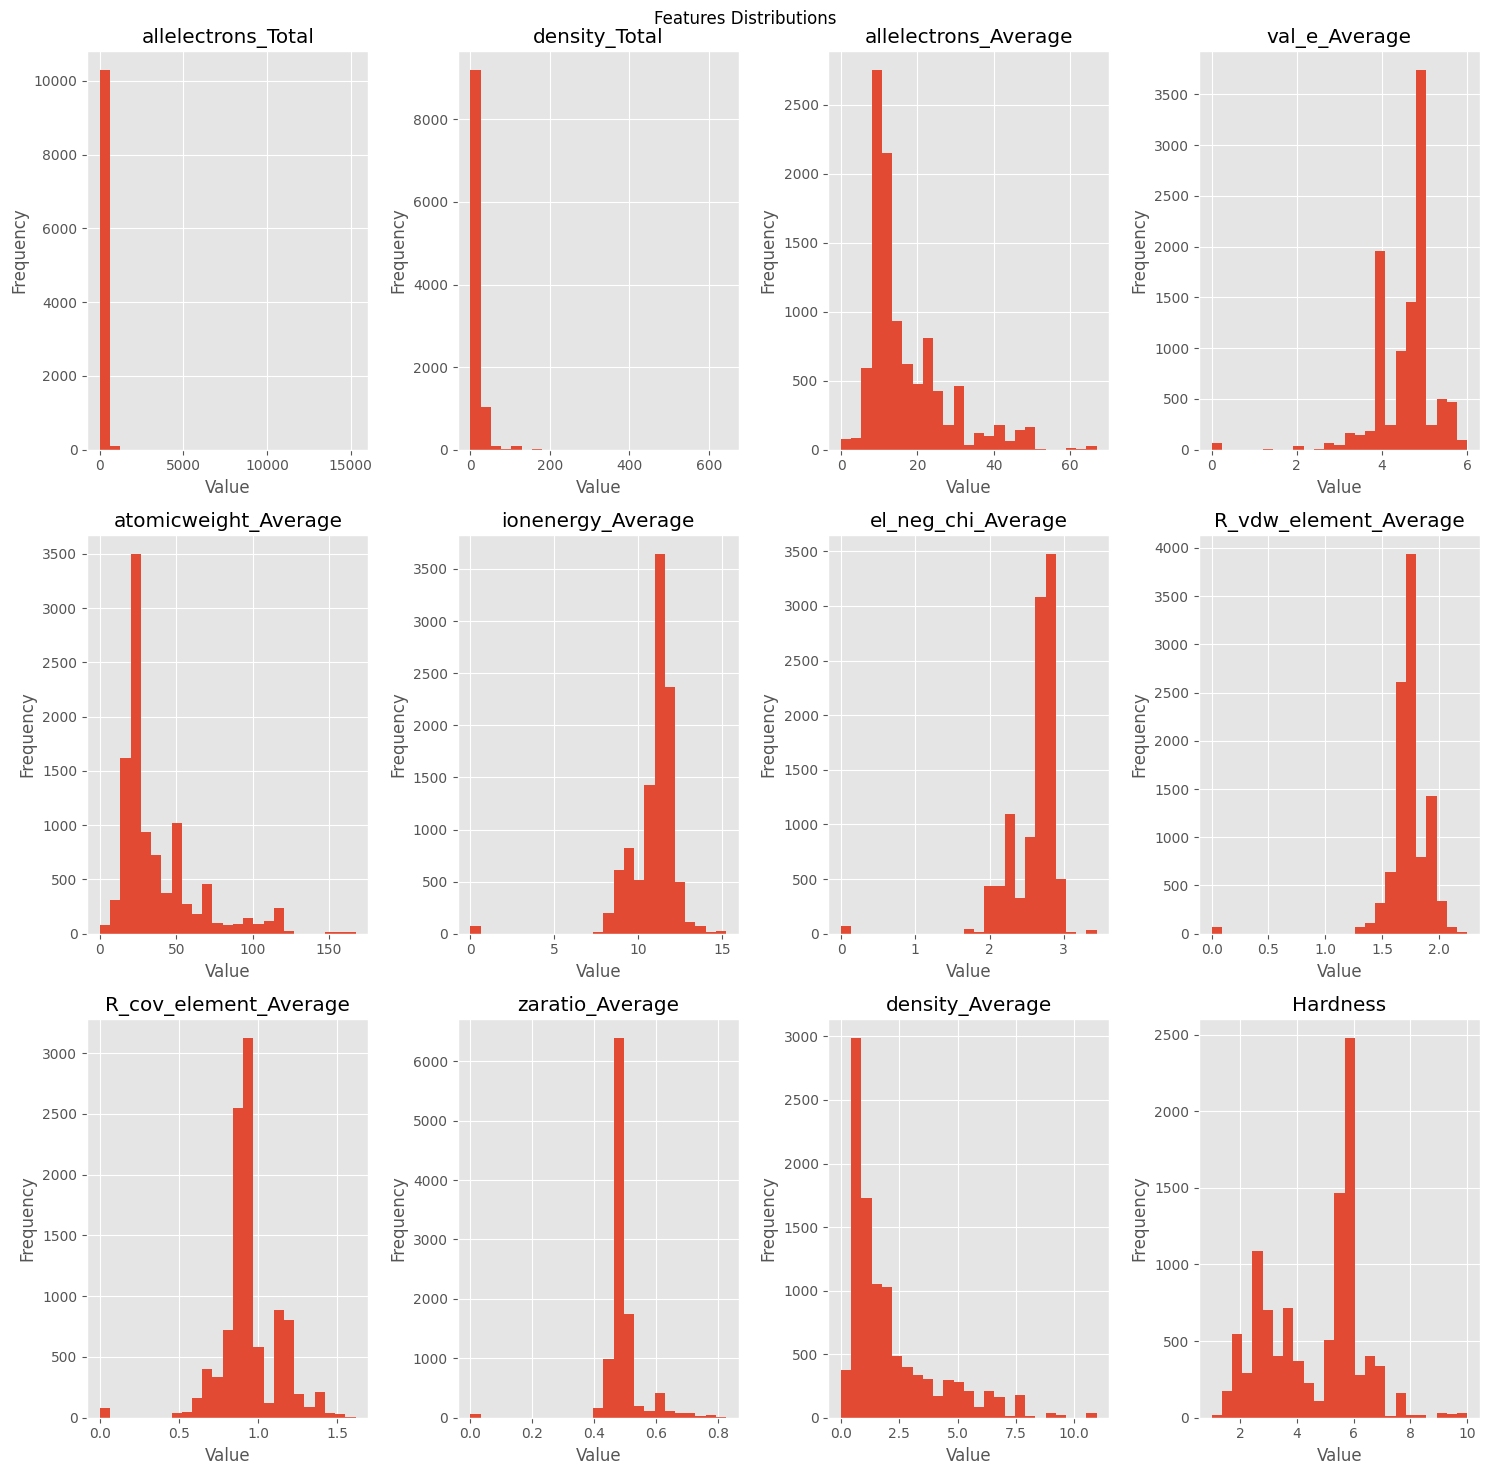

In [7]:
m, n = data_train.shape
grid = np.arange(n).reshape(-1, 4)
fig, axs = plt.subplots(grid.shape[0], grid.shape[1], figsize=(15,15), sharex=False)
counter = 0
plt.suptitle('Features Distributions')
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        feature_name = data_train.columns[counter]
        axs[i, j].hist(data_train[feature_name], bins=25)
        axs[i, j].set_title(feature_name)
        axs[i, j].set_xlabel('Value')
        axs[i, j].set_ylabel('Frequency')
        counter += 1
plt.tight_layout()
plt.show()

In [8]:
def IQR(col):
    arr = np.array(col)
    arr = np.sort(arr)
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    return q3 - q1

def Q3(col):
    arr = np.array(col)
    arr = np.sort(arr)
    return np.percentile(arr, 75)

def Q1(col):
    arr = np.array(col)
    arr = np.sort(arr)
    return np.percentile(arr, 25)

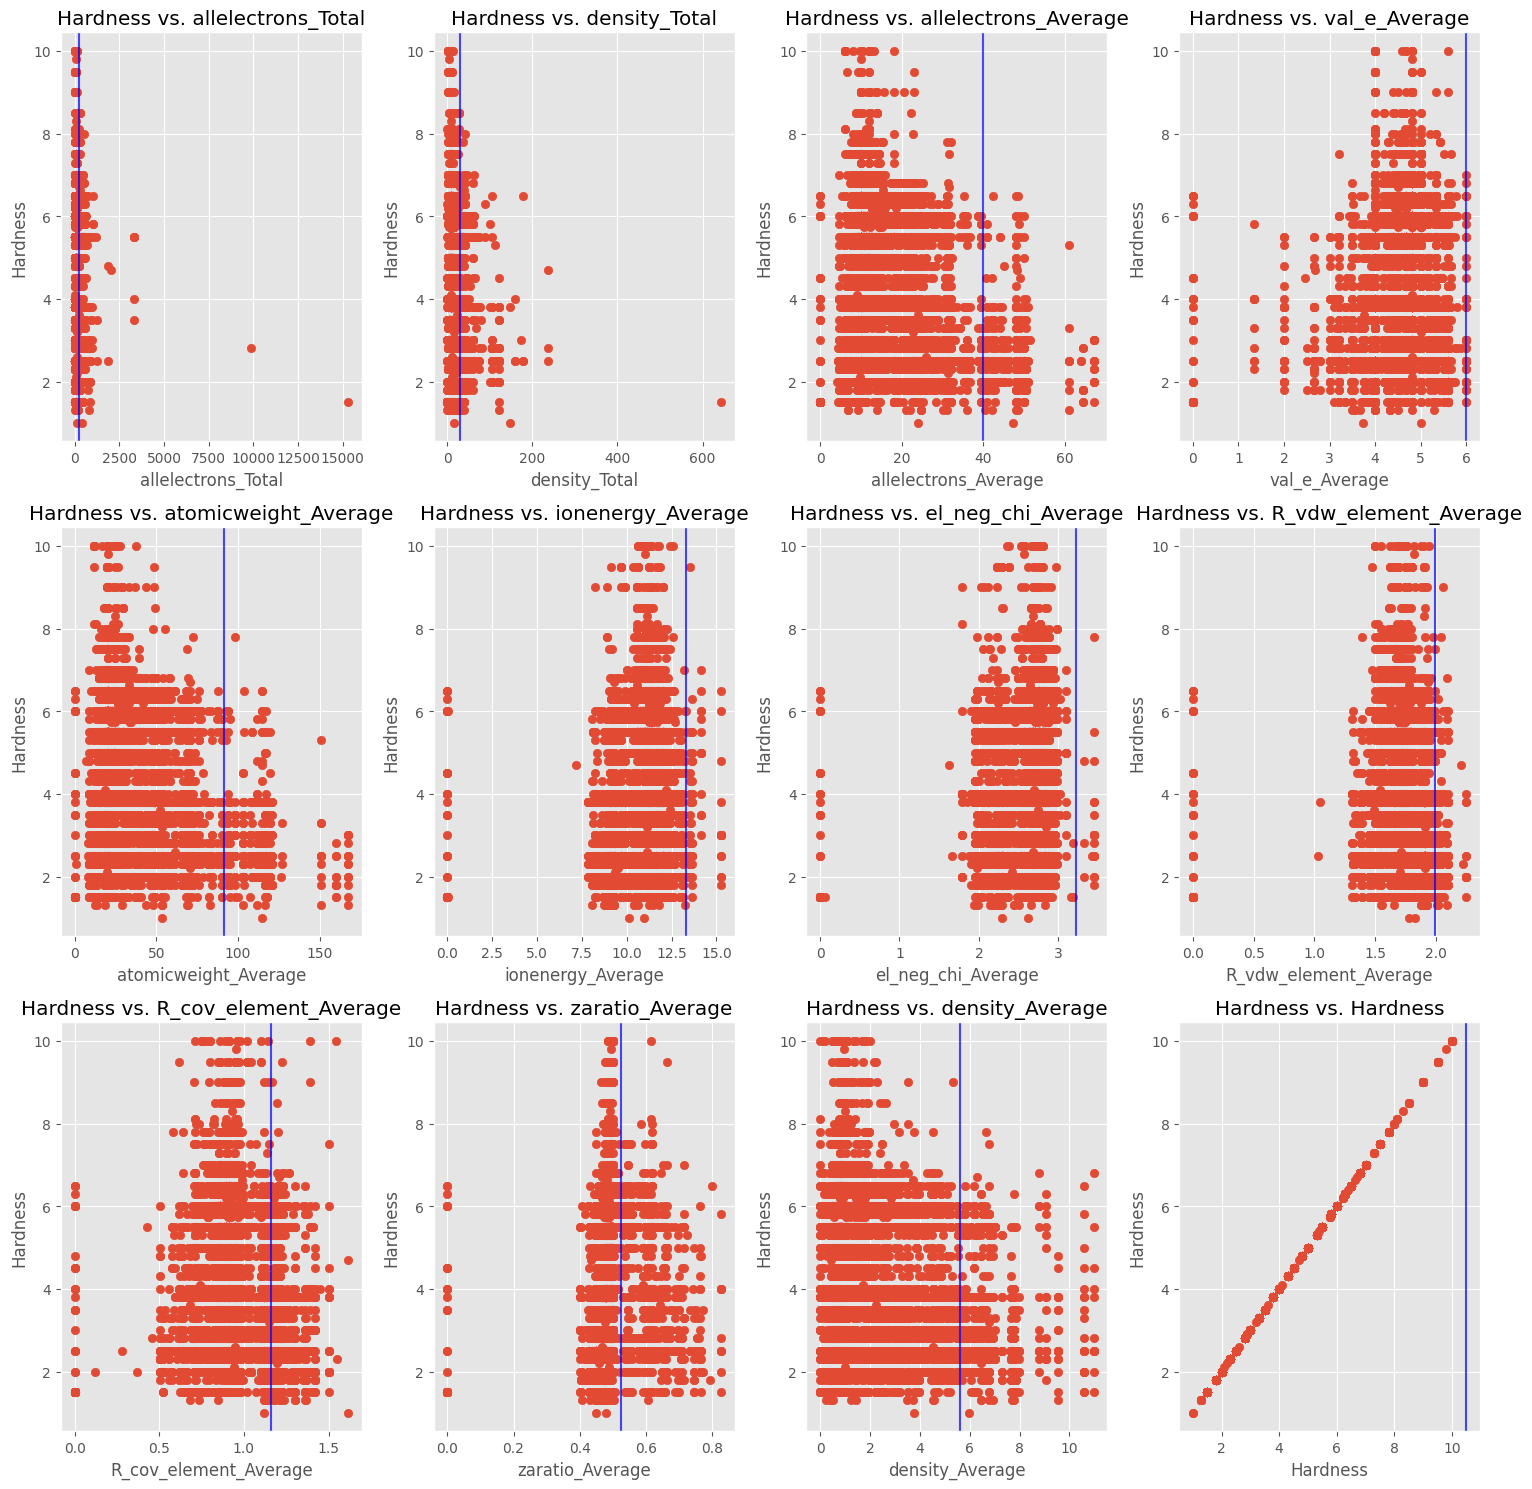

In [9]:
m, n = data_train.shape
grid = np.arange(n).reshape(-1, 4)
fig, axs = plt.subplots(grid.shape[0], grid.shape[1], figsize=(15,15))
counter = 0
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        feature_name = data_train.columns[counter]
        axs[i,j].scatter(x=data_train[feature_name], y=data_train['Hardness'])
        axs[i, j].set_title(f'Hardness vs. {feature_name}')
        axs[i, j].set_ylabel('Hardness')
        axs[i, j].set_xlabel(f'{feature_name}')
        axs[i, j].axvline(Q3(data_train[feature_name]) + IQR(data_train[feature_name]*1.5), c='blue', alpha=0.7)
        counter += 1
        
plt.tight_layout()
plt.show()

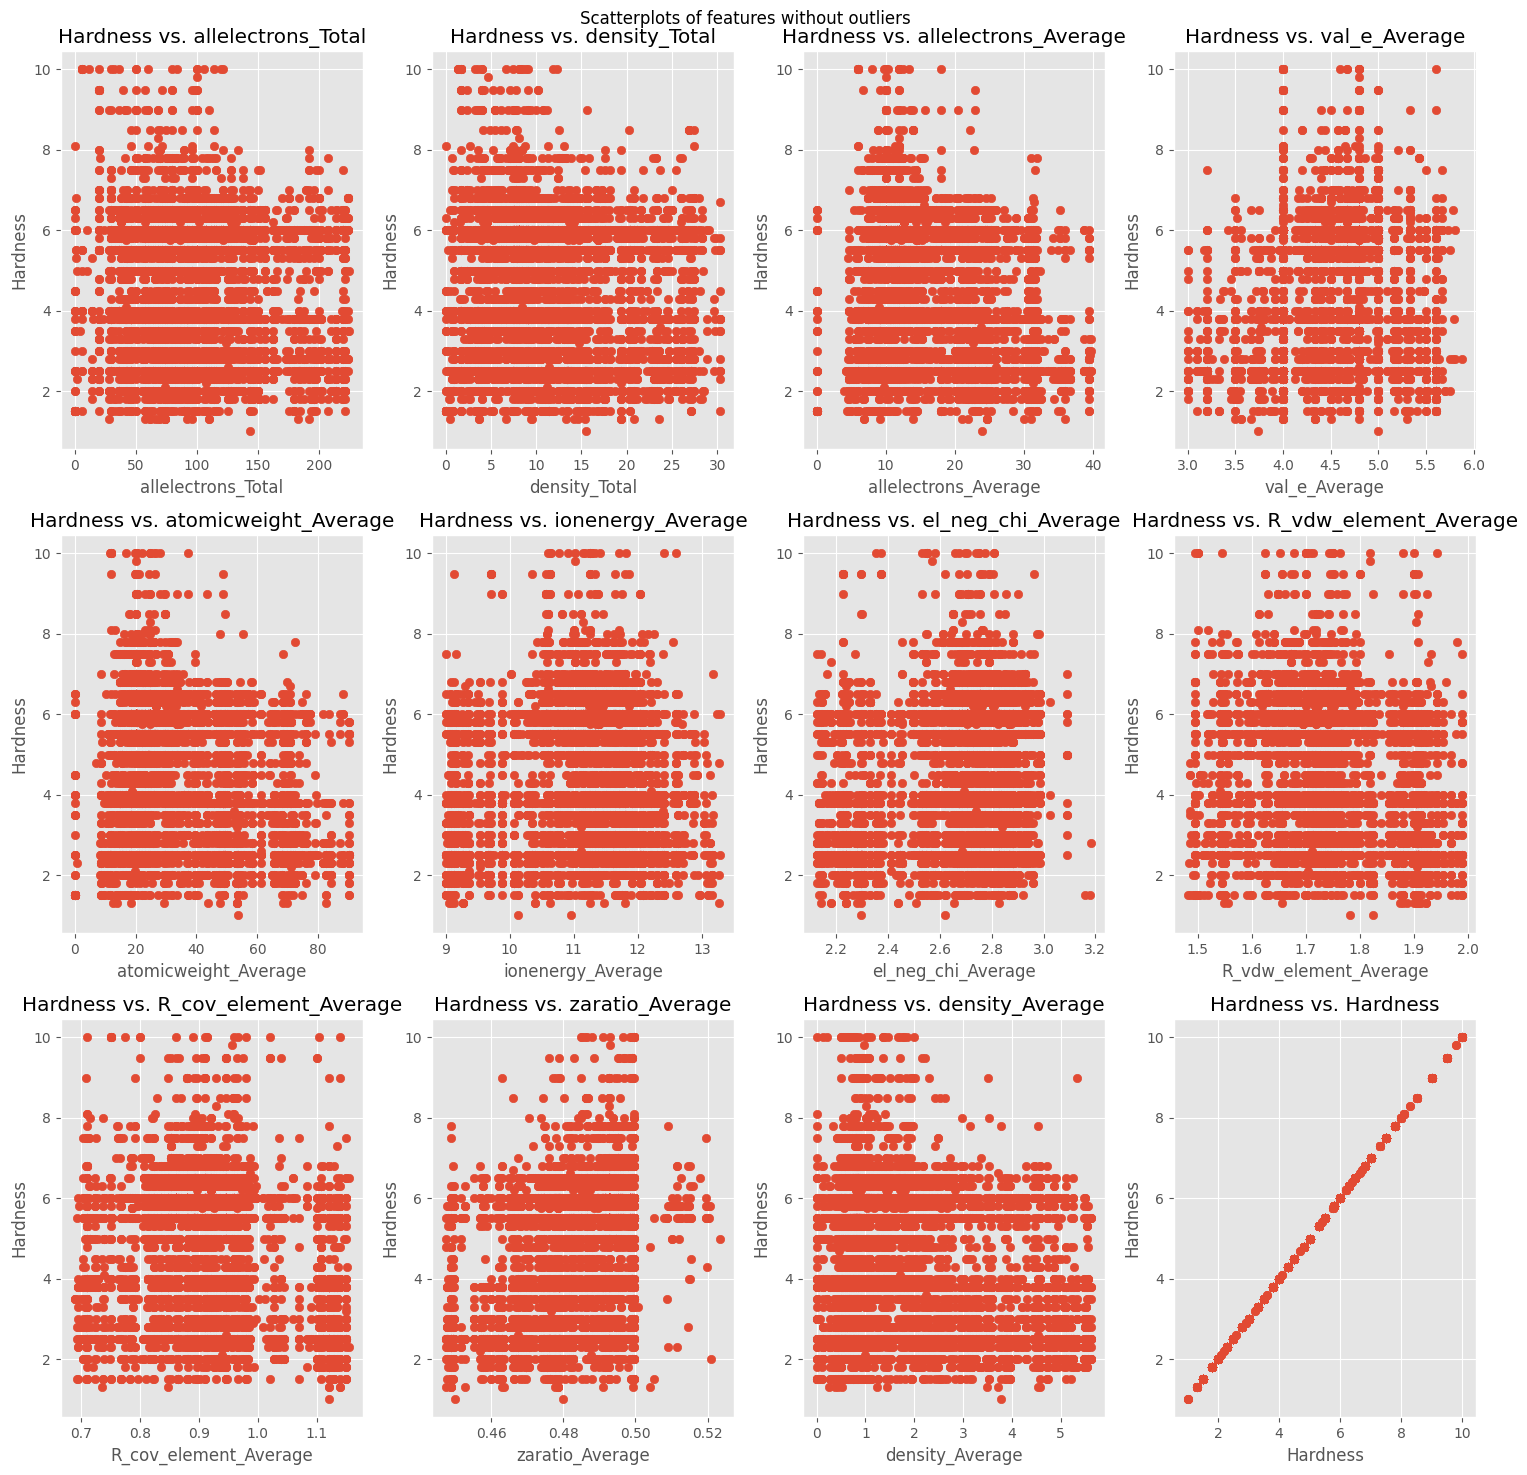

In [10]:
grid = np.arange(n).reshape(-1, 4)
fig, axs = plt.subplots(grid.shape[0], grid.shape[1], figsize=(15,15))
counter = 0
plt.suptitle("Scatterplots of features without outliers")
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        feature_name = data_train.columns[counter]
        # calc iqr and q3
        col_IQR = IQR(data_train[feature_name])
        col_Q3 = Q3(data_train[feature_name])
        col_Q1 = Q1(data_train[feature_name])
        # filter out the outliers
        col_no_outliers = data_train.loc[(data_train[feature_name] > col_Q1 - 1.5 * col_IQR) & (data_train[feature_name] < col_Q3 + 1.5 * col_IQR), [feature_name, 'Hardness']]
        # plot scatterplots
        axs[i,j].scatter(x=col_no_outliers[feature_name], y=col_no_outliers['Hardness'])
        axs[i, j].set_title(f'Hardness vs. {feature_name}')
        axs[i, j].set_ylabel('Hardness')
        axs[i, j].set_xlabel(f'{feature_name}')
        #axs[i, j].axvline(Q3(data_train[feature_name]) + IQR(data_train[feature_name]*1.5), c='blue', alpha=0.7)
        counter += 1
        
plt.tight_layout()
plt.show()

<Axes: >

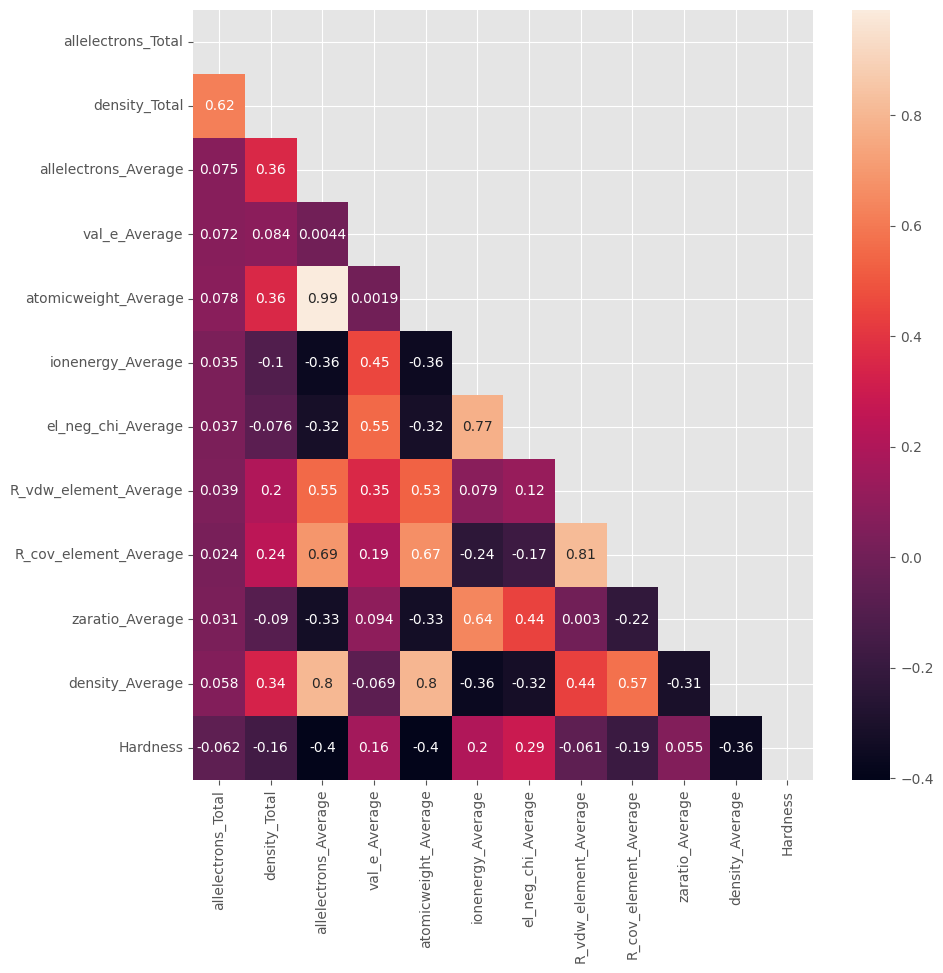

In [11]:
import seaborn as sns
# correlation matrix
corr = data_train.corr()
# mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(data_train.corr(), mask=mask, annot=True)

<Axes: title={'center': 'Mean and Standard Deviation of each feature'}>

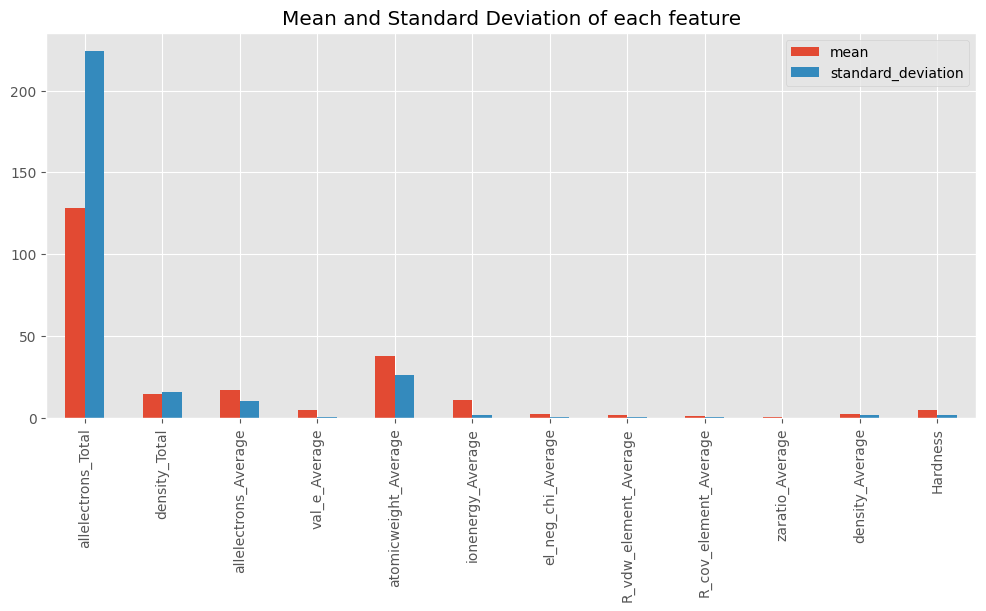

In [12]:
stat_df = pd.DataFrame([data_train.mean(), data_train.std()]).transpose()
stat_df = stat_df.rename({0: 'mean', 1: 'standard_deviation'}, axis=1)
stat_df.plot(kind='bar', title='Mean and Standard Deviation of each feature', figsize=(12,5))

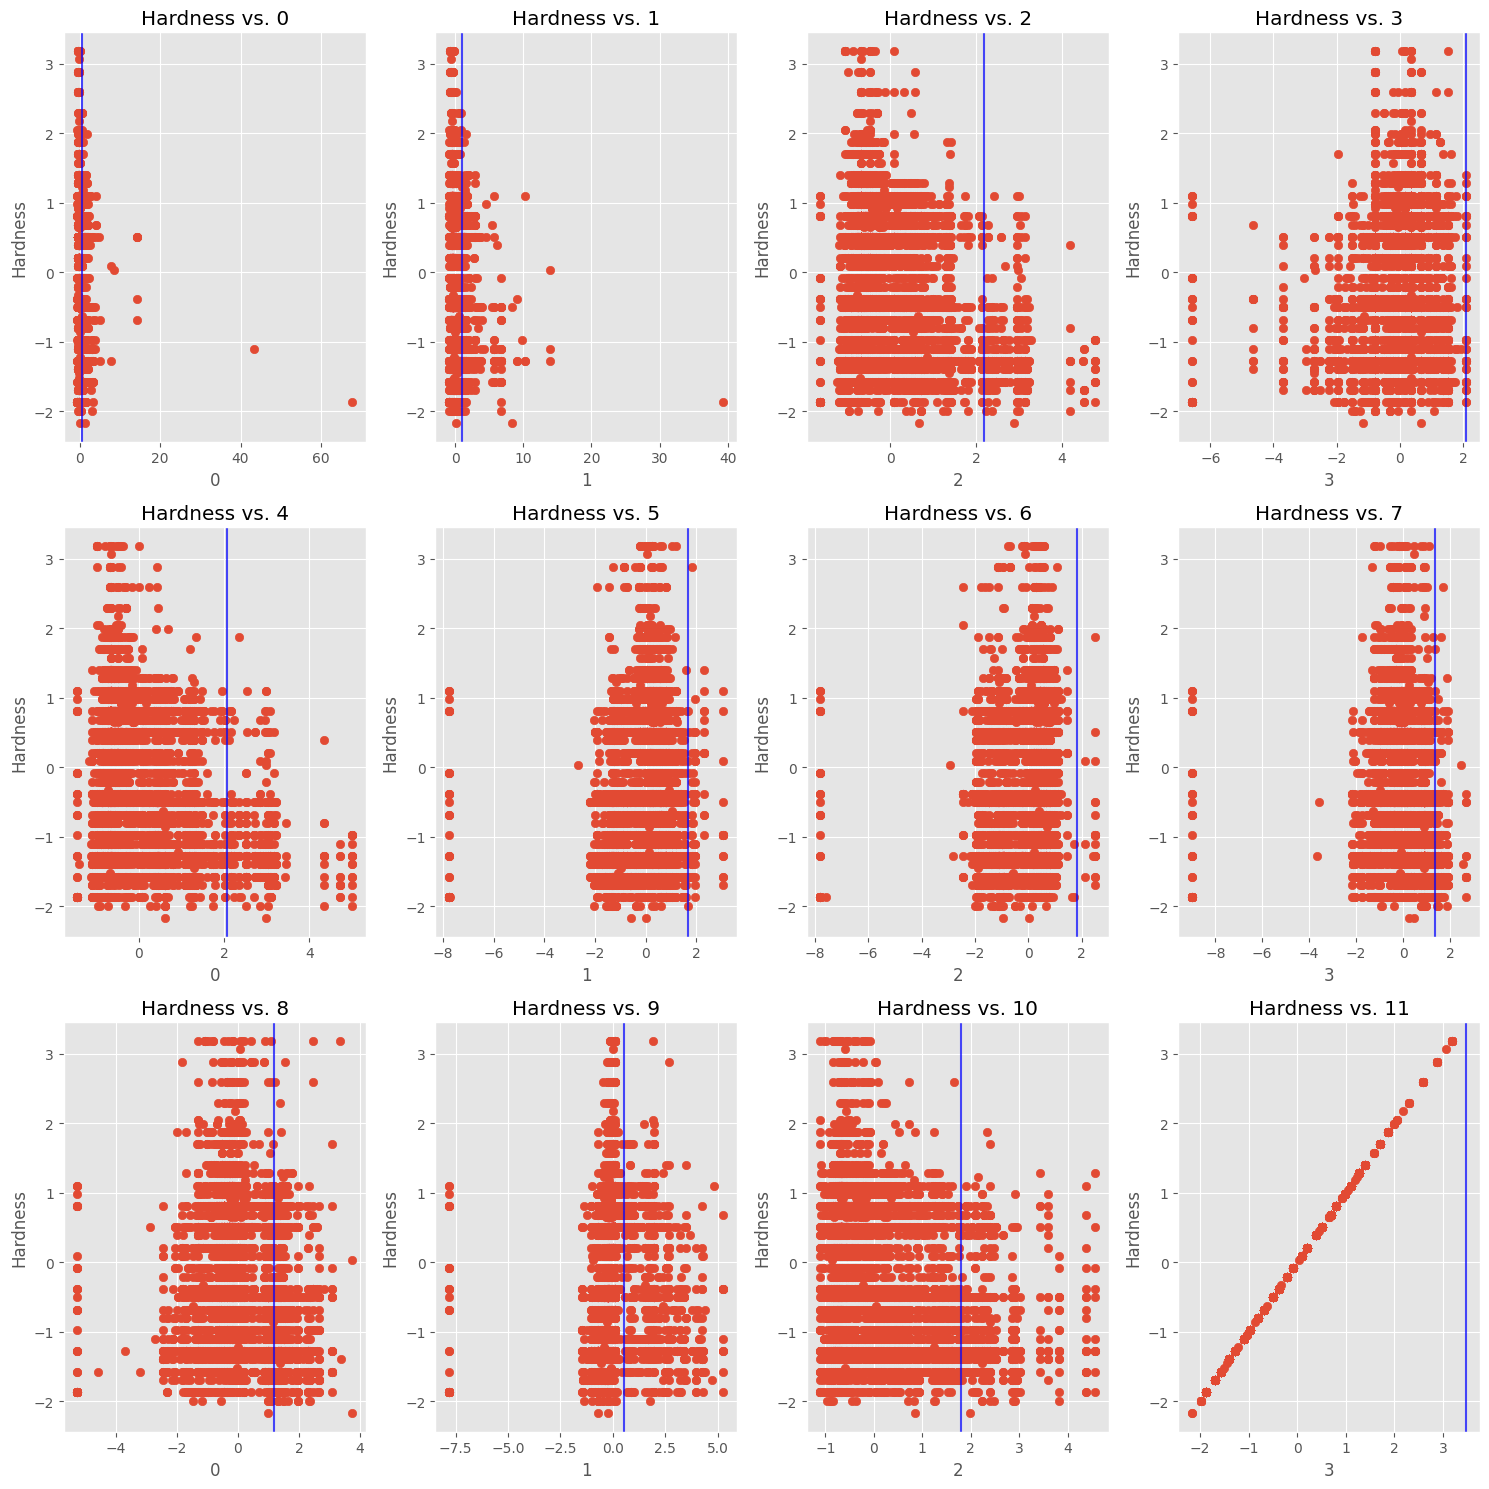

In [13]:
m, n = data_train.shape
grid = np.arange(n).reshape(-1, 4)
fig, axs = plt.subplots(grid.shape[0], grid.shape[1], figsize=(15,15))
counter = 0
scaler = StandardScaler()
data_train_scaled = scaler.fit_transform(data_train)

for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        #feature_name = data_train_scaled.columns[counter]
        axs[i,j].scatter(x=data_train_scaled[:,counter], y=data_train_scaled[:,-1])
        axs[i, j].set_title(f'Hardness vs. {counter}')
        axs[i, j].set_ylabel('Hardness')
        axs[i, j].set_xlabel(f'{j}')
        axs[i, j].axvline(Q3(data_train_scaled[:,counter]) + IQR(data_train_scaled[:,counter]*1.5), c='blue', alpha=0.7)
        counter += 1
        
plt.tight_layout()
plt.show()

In [14]:
def get_pairs(df, n = 100):
    from random import randint
    i = 0
    tuples = []
    while i < n:
        x = df.columns[randint(0,len(df.columns)-1)]
        y = df.columns[randint(0,len(df.columns)-1)]
        while x == y or (x,y) in tuples or (y,x) in tuples:
            y = df.columns[randint(0,len(df.columns)-1)]
        tuples.append((x,y))
        i+=1
    return tuples

In [15]:
pairs = get_pairs(data_train, n=9)

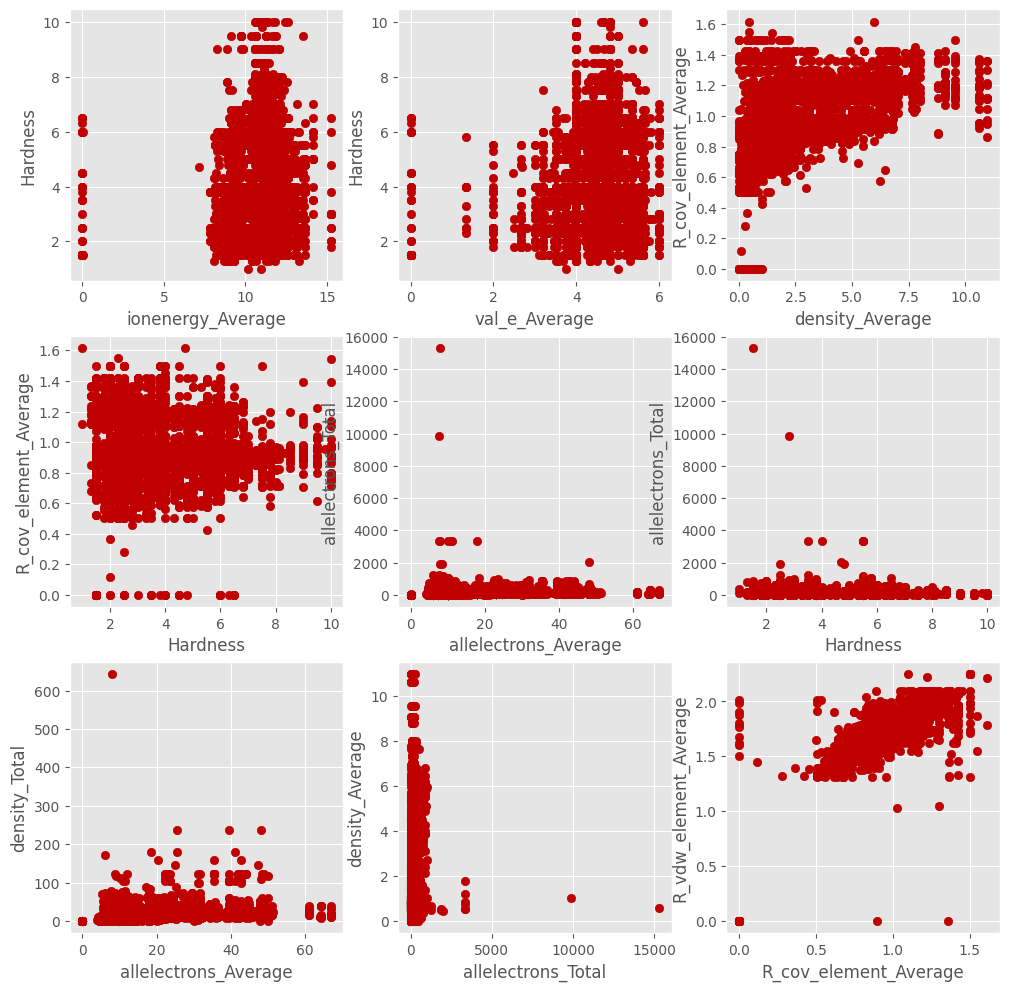

In [16]:
fig, axs = plt.subplots(3,3, figsize = (12,12))
i = 0
for rows in axs:
    for ax in rows:
        ax.scatter(data_train[pairs[i][0]],data_train[pairs[i][1]], color = "#C00000")
        ax.set_xlabel(pairs[i][0])
        ax.set_ylabel(pairs[i][1])
        i+=1

In [17]:
n_components = 3
pca = PCA(n_components=n_components)
data_train_scaled_reduced_x = pca.fit_transform(data_train_scaled)
pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_)

(array([0.37790844, 0.20619601, 0.12500519]), 0.7091096366150917)

In [18]:
df_pca = pd.DataFrame(data_train_scaled_reduced_x, columns=[f'PC{n}' for n in range(1,n_components+1)])

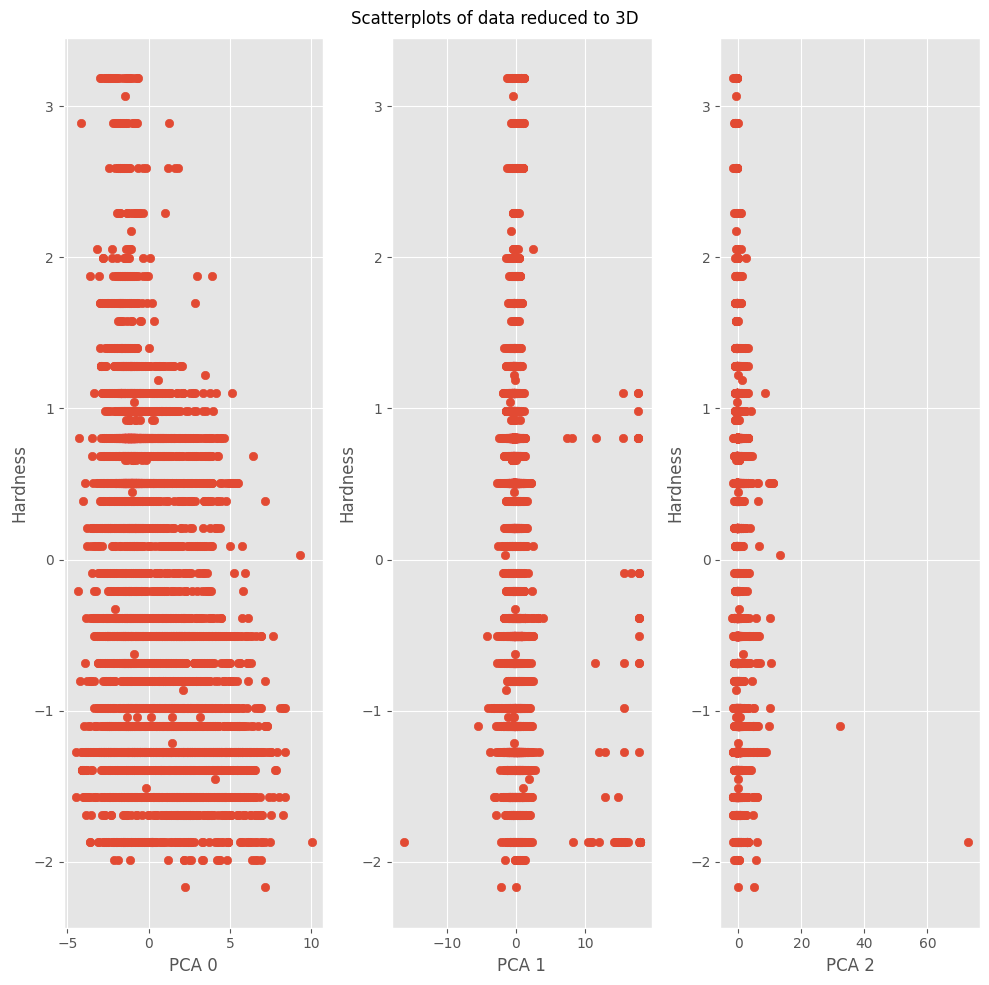

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(10,10))
plt.suptitle('Scatterplots of data reduced to 3D')
for col in range(data_train_scaled_reduced_x.shape[1]):
    ax[col].scatter(data_train_scaled_reduced_x[:,col], data_train_scaled[:, -1])
    ax[col].set_ylabel('Hardness')
    ax[col].set_xlabel(f'PCA {col}')
plt.tight_layout()
plt.show()
    

In [20]:
fig = px.scatter_3d(df_pca, x = 'PC1', y = 'PC2', z = 'PC3').update_traces(marker = dict(color = "#C00000"))
fig.show()

___
___

In [57]:
# divide train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(data_train.iloc[:, :11], data_train.iloc[:, -1], test_size=0.2)

In [58]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8325, 11), (2082, 11), (8325,), (2082,))

In [59]:
models = [LinearRegression(), RandomForestRegressor(), SVR(), XGBRegressor()]
scores = []
counter = 0
cv = KFold(4)

for model in models:
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    cv_score = cross_val_score(estimator=pipe, X=data_train.iloc[:,:-1], y=data_train.iloc[:,-1], cv=cv, scoring='neg_median_absolute_error')
    scores.append(-cv_score)

    print(f"Model: {model.__class__.__name__}")
    print(f"CV RMSE: {np.mean(scores[counter]):.4f} +/- {np.std(scores[counter]):.4f}")
    counter += 1
    

Model: LinearRegression
CV RMSE: 0.9686 +/- 0.0073


KeyboardInterrupt: 

___
___

In [65]:
class NeuralNetRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(11, 36)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(36, 18)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(18, 9)
        self.act3 = nn.ReLU()
        self.output = nn.Softmax(9, 9)
        
    def forward(self, x):
        for layer, act in zip([self.layer1, self.layer2, self.layer3], [self.act1, self.act2, self.act3]):
            x = act(layer(x))
        x = self.output(x)
        return x
    
    def loss(self, yhat, y):
        return torch.median(torch.abs(y - yhat))
    
    # def optimize(self, lr):
    #     return optim.SGD(self.parameters, lr)


In [66]:
train_scaler = StandardScaler()
X_train_scaled = train_scaler.fit_transform(X_train)
X_val_scaled = train_scaler.transform(X_val)

In [67]:
X_train_scaled = torch.from_numpy(X_train_scaled)
y_train = torch.from_numpy(np.array(y_train))
X_val_scaled = torch.from_numpy(X_val_scaled)
y_val = torch.from_numpy(np.array(y_val))

In [68]:
X_train_scaled = X_train_scaled.float()
y_train = y_train.float()
X_val_scaled = X_val_scaled.float()
y_val = y_val.float()

In [77]:
learning_rate = 0.01

model = NeuralNetRegression()
optimizer_train = optim.SGD(model.parameters(), lr=learning_rate)
optimizer_val = optim.SGD(model.parameters(), lr=learning_rate)

train_loss_list = []
val_loss_list = []

num_iter = 500

for epoch in tqdm(range(num_iter), desc='NN Training'):
    # train score
    optimizer_train.zero_grad()
    
    yhat_train = model(X_train_scaled)
    train_loss = model.loss(yhat_train, y_train)
    train_loss.backward()
    # update parameters
    optimizer_train.step()
    # add loss to list
    train_loss_list.append(train_loss.detach().numpy())
    
    # val score
    yhat_val = model(X_val_scaled)
    val_loss = torch.median(torch.abs(y_val - yhat_val))
    # add loss to list
    val_loss_list.append(val_loss.detach().numpy())
    
    #print(f'epoch: {epoch} / training loss: {train_loss.data} / validation loss: {val_loss.data}')


NN Training: 100%|██████████| 500/500 [10:49<00:00,  1.30s/it]


___
___
___

In [93]:
# save feature names
features = data_train.columns
# put data to PyTorch tensor
X = torch.tensor(data_train.drop("Hardness", axis=1).to_numpy())
y = torch.tensor(data_train['Hardness'].to_numpy())
# split to train and test(val)
train_split = int(0.8*len(X))
X_train, y_train, X_val, y_val = X[:train_split], y[:train_split], X[train_split:], y[train_split:]

8325